# Training models for pulmonary nodule detection on LUNA16 dataset

In this tutorial you will learn how to train models on popular [LUNA16](http://luna16.grand-challenge.org) competition dataset (scans from [LIDC-IDRI])(https://wiki.cancerimagingarchive.net/display/Public/LIDC-IDRI).

Notebook is divided into four parts:
1. Preparation of dataset containing CT-scans crops
2. Training a ready-made model from recommended RadIO model zoo, e.g. [**Keras3DUnet**](https://analysiscenter.github.io/radio/api/keras_3dunet.html)
3. Training a popular model from dataset/models zoo, e.g. [**V-Net**](https://analysiscenter.github.io/dataset/api/dataset.models.tf.vnet.html)
4. Integrating custom model with RadIO framework

Before proceeding to the plan, we will make some standard imports:

In [1]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Part I. Prepare dataset of crops

Traininig a neural network on whole CT-scans is not yet practically approachable, as they weight too much (300-500mb+). Therefore using smaller 3D parts, crops, would be a natural way to tackle volumetric information. Cropping parts with/without nodules will also facilitate better sampling and allow to tune balance of positive/negative examples in batch more accurately. RadIO contains ready-made preprocessing pipeline which will create a dataset with crops. You may use LUNA16 challenge dataset in MetaImage format to run this tutorial.

**Note**: You will also need **annotations.csv** file with annotation in format similar to file provided for the LUNA16 dataset.

In [2]:
import radio
from radio import dataset as ds
from radio import CTImagesMaskedBatch as CTIMB

# read annotation
nodules = pd.read_csv('/data/MRT/luna/CSVFILES/annotations.csv')

# create index and dataset
lunaix = ds.FilesIndex(path='/data/MRT/luna/s*/*.mhd', no_ext=True)
lunaset = ds.Dataset(index=lunaix, batch_class=CTIMB)

If you need to split your dataset into train/test/validation parts, you can use `.cv_split` method. For example, splitting dataset into 90% for train, 10% for test and 0% for validation will be:

In [3]:
lunaset.cv_split(0.9, shuffle=True)

Now original dataset is divided into train and test parts:

In [4]:
len(lunaset.train), len(lunaset.test)

(799, 89)

Next, we need to write down preprocessing workflow. 

Function **split_dump** from `radio.pipelines` returns basic workflow, including normalizing [**Hounsfield Units**](https://en.wikipedia.org/wiki/Hounsfield_scale), resizing all scans to fixed scans and in at same time unifying its spacing to desired one. After preprocessing **split_dump** function samples smaller crops of desired shape **(32, 64, 64)** with and without cancer nodules. Workflow will also create masks based on nodules location and dump all components, e.g. `masks`, `images`, into fast [**blosc**](http://blosc.org/pages/blosc-in-depth/) format.

Crops with cancer nodules will be dumped to `cancer_path` and crops without any nodules will be dumped to `non_cancer_path`. It allows managing balance of positive/negative examples in batch later during training.

You may want to pass additioanl paramteres as `kwargs`: 

In [5]:
from radio.pipelines import split_dump

SPACING = (1.7, 1.0, 1.0)  # spacing of scans after spacing unification
SHAPE = (400, 512, 512)  # shape of scans after spacing unification
PADDING = 'reflect'  # 'reflect' padding-mode produces the least amount of artefacts
METHOD = 'pil-simd'  # robust resize-engine

kwargs_default = dict(shape=SHAPE, spacing=SPACING, padding=PADDING, method=METHOD)

In [6]:
crop_pipeline = split_dump(cancer_path='/data/lunaset_split/train/cancer/', 
                           non_cancer_path='/data/lunaset_split/train/ncancer/',
                           nodules=nodules, fmt='raw', nodule_shape=(32, 64, 64),
                           batch_size=20, **kwargs_default)

Pass dataset directly to pipeline and run it, for example for `lunaset.train` sub-dataset:

(Note, it may take some time, so better grab a coffee)

In [8]:
(lunaset.train >> crop_pipeline).run()

You may want to prepare test part in similar way, but do not forget to change `cancer_path` and `non_cancer_path`. In this tutorial we will skip it.

### Part II. Training a ready-to-use model implemented in Keras: 3D U-Net

**RadIO** contains a small but growing zoo of models in Keras and Tensorflow. In this part you will perform training a 3D U-Net architecture for pulmonary nodule segmentation using dataset of CT-scans crops you prepared earlier.

In [7]:
DIR_CANCER = '/data/lunaset_split_new/train/cancer/*'
DIR_NCANCER = '/data/lunaset_split_new/train/ncancer/*'

Similar to preprocessing, let's build a training pipeline. This time, you will need 2 datasets, one for crops with nodules and another without them, that's why they were dumped in different folders. Remeber, that masks and some other special information is also dumped, so it can be easily loaded on request.

First of all, we create two indices and two datasets corresponding to them:

In [8]:
cix = ds.FilesIndex(path=DIR_CANCER, dirs=True)
ncix = ds.FilesIndex(path=DIR_NCANCER, dirs=True)

cancerset = ds.Dataset(index=cix, batch_class=CTIMB)
ncancerset = ds.Dataset(index=ncix, batch_class=CTIMB)

How can we use both datasets in a same time during training? Package **dataset** allows to `merge` several pipelines into one requiring only specification of **batch_size** parameter for each of them. Say, we would want take 4 crops with nodules and 4 without them, in total batch_size of 8 crops of (32, 64, 64) size. Let's import a ready made pipeline **combine_crops** for this problem:

In [167]:
from radio.pipelines import combine_crops
from utils import show_slices # function for plotting batch masks and images
combine_pipeline = combine_crops(cancerset, ncancerset, batch_sizes=(4, 4))

In [170]:
# Here we generate one batch with 4 cancer crops and 4 non-cancer crops
batch = combine_pipeline.next_batch()

Let's look inside of generated batch. To do that we use `show_slices` function:

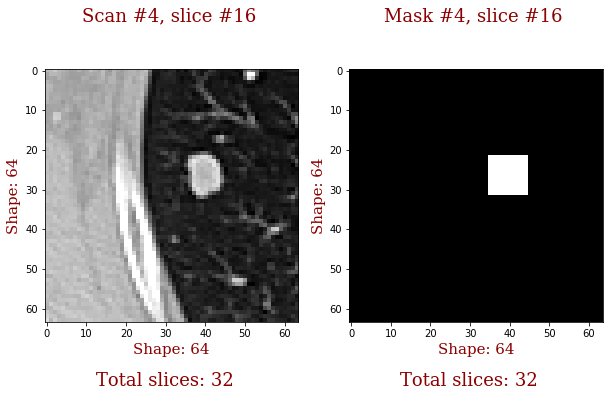

In [171]:
show_slices(batch, scan_indices=4, ns_slice=16, clims=[(0, 255), (0, 1)],
            components=('images', 'masks'), grid=False)

Next step is the model: import and desciption of configuration dict. Model requires specification of input crops and masks sizes (will be same) as well as Optimizer and Loss function; e.g. use Adam for training and Dice loss funciton for segmentation:

In [15]:
from radio.models import Keras3DUNet
from radio.models.keras.losses import dice_loss

unet_config = dict(
    input_shape = (1, 32, 64, 64),
    num_targets = 1,
    loss= dice_loss
)

After that, let's add one more part to training pipeline specifying model and training params by chaining `.init_model` and `.train_model` pipeline methods:

In [16]:
from radio.dataset import F

train_unet_pipeline = (
    combine_crops(cancerset, ncancerset, batch_sizes=(4, 4))
    .init_model(
        name='3dunet', model_class=Keras3DUNet,
        config=unet_config, mode='static'
    )
    .train_model(
        name='3dunet',
        x=F(CTIMB.unpack, component='images', data_format='channels_first'),
        y=F(CTIMB.unpack, component='masks', data_format='channels_first')
    )
)

Here `train_model` employ custom **CTIMB.unpack** method that helps to unpack specific components from batch and put them into desired alias of keras network: `images` component goes to `x` and `masks` into `y`.

If you want to try a keras network for classification, you may simply pass component for y's unpack to `classification_targets`. That way, unpack would transform masks into binary classification (`nodule` vs. `non-nodule`) target based on threshold of amount of cancer voxels inside the crop to label `nodule`. See [documentation](https://analysiscenter.github.io/radio/intro/models.html) for details.

Then, the moment of truth:

In [18]:
train_unet_pipeline.run()

After execution is finished, you may `.save` keras model:

In [19]:
keras_unet = train_unet_pipeline.get_model_by_name('3dunet')
keras_unet.save('/path/to/keras_3d_unet/weights')

If you later would like to access it, that would be easy by adding `path` in `model_config` and redefining and running same pipeline again:

In [24]:
unet_config.update({'path': '/path/to/keras_3d_unet/weights'})

train_unet_pipeline = (
    combine_crops(cancerset, ncancerset, batch_sizes=(4, 4))
    .init_model(
        name='3dunet', model_class=Keras3DUNet,
        config=unet_config, mode='static'
    )
    .train_model(
        name='3dunet',
        x=F(CTIMB.unpack, component='images', data_format='channels_first'),
        y=F(CTIMB.unpack, component='masks', data_format='channels_first')
    )
)

train_unet_pipeline.run()

**Note**: we have created a new pipeline instance to avoid model names collision when init_model method is called second time.

### Part 3. Training a model from radio.dataset.models zoo: V-Net

Dataset library used by RadIO contains a zoo of many popular model architecture in tensorflow. In this part you will learn to train V-Net (volumetric u-net) for same task with same preprocessing pipeline. All you need is to define config of dataset's v-net model:

In [59]:
from radio.dataset.models.tf import VNet
# We use Tversky loss here cause it performs slightly better than dice
from radio.models.tf.losses import tversky_loss
import tensorflow as tf

Using TensorFlow backend.


In [60]:
vnet_config = {
    'inputs': dict(
        images={'shape': (32, 64, 64, 1)},
        labels={'name': 'targets', 'shape': (32, 64, 64, 1)}
    ),
    'loss': tversky_loss,
    'optimizer': 'Adam',
}
vnet_config['input_block/inputs'] = 'images'
vnet_config['head/layout'] = 'cna'
vnet_config['head/activation'] = tf.nn.sigmoid
vnet_config['head/kernel_size'] = 1
vnet_config['head/num_classes'] = 1

Subpackage **dataset.models** has highly parametrized architectures that allow to perform experiments by combining different paramteres without changing model's code. It greatly facilitates clear and reproducible experiment settings.

In example above you descibed configuration dictionary for V-Net model which will be trained on crops with Adam optimizer, tversky loss. Slight modifications are added to head of the network, last convolutional block would consist of convolution with (1, 1, 1) kernel, 1 filter, following batch normalisation layer and sigmoid activation function. See dataset [documentation](https://analysiscenter.github.io/dataset/intro/tf_models.html) for details.

In [61]:
from IPython.display import clear_output
from radio.dataset import V, F

train_vnet_pipeline = (
    combine_crops(cancerset, ncancerset, batch_sizes=(4, 4))
    .init_variable('loss_history', init_on_each_run=list)
    .init_variable('current_loss', init=float)
    .init_model(
        name='vnet', model_class=VNet,
        config=vnet_config, mode='static'
    )
    .train_model(
        name='vnet', fetches='loss', save_to=V('current_loss'), mode='w',
        feed_dict={'images': F(CTIMB.unpack, component='images'),
                   'targets': F(CTIMB.unpack, component='masks')}
    )
    .print("Current loss:")
    .print(V('current_loss'))
    .update_variable('loss_history', value=V('current_loss'), mode='a')
    .call(lambda x: clear_output(wait=True))
)

In [ ]:
train_vnet_pipeline.run()

Current loss:
-0.49989


Let's visualize loss changes through learning process:

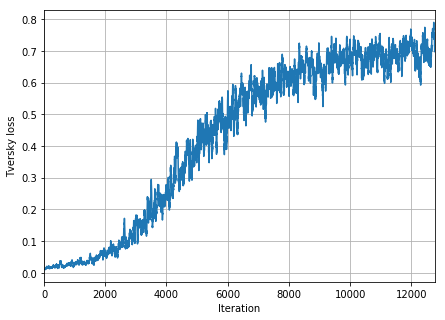

In [26]:
loss_history = (
    pd.Series(train_vnet_pipeline.get_variable('loss_history'))
    .rolling(32)
    .mean()
    .transform(lambda x: -x)
)

plt.figure(figsize=(7, 5))
loss_history.plot(grid=True)
plt.xlabel('Iteration')
plt.ylabel('Tversky loss')

Usually, it's quiet usefull to have a look on predictions:

In [172]:
vnet_model = train_vnet_pipeline.get_model_by_name('vnet')
predicted_masks = vnet_model.predict(feed_dict={'images': batch.unpack('images')})

True mask coupled with CT-crop looks like:

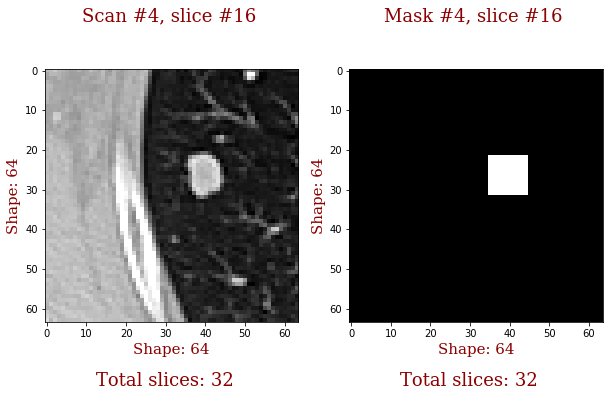

In [173]:
show_slices(batch, scan_indices=4, ns_slice=16, clims=[(0, 255), (0, 1)],
            components=('images', 'masks'), grid=False)

Below you can see predicted mask coupled with CT-crop:

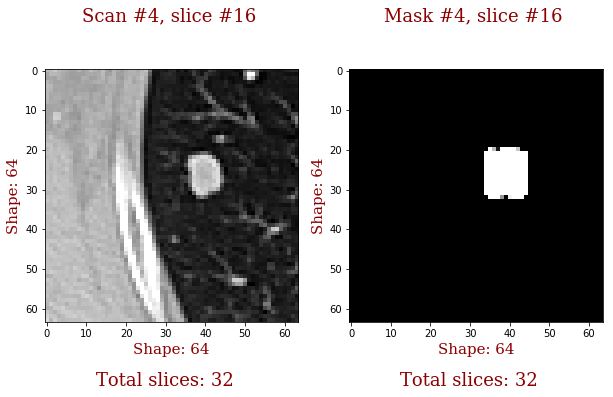

In [174]:
batch.masks = predicted_masks.reshape(-1, 64, 64)
show_slices(batch, scan_indices=4, ns_slice=16, clims=[(0, 255), (0, 1)],
            components=('images', 'masks'), grid=False)

### Part 4. Writing custom tensorflow model compatible with the same pipeline

In this part you will see, how to train your own models using RadIO framework. The easiest way would be to write your model in tensorflow or keras and use `.import_model()` in pipeline. Let's implement a simple 3D convolutional encoder-decoder architecture via tensorflow.

First of all, you need to keep in mind that your custom model must be compatible with `pipeline`'s model specific methods. An easy way to provide this would be to inherit `BaseModel` class and redefine its **`build`** method for building model's graph in tensorflow, **train** method as it will be used by pipeline's **.train_model** and **predict** method to be able to call pipeline's **.predict_model**. Additionaly, you can provide implementation for save and load methods. See documentation of [BaseModel](https://analysiscenter.github.io/dataset/api/dataset.models.html#dataset.models.BaseModel) to make sense of its possibilities.

In [3]:
import tensorflow as tf
from radio.dataset.models import BaseModel

In [32]:
class TFCustomModel(BaseModel):

    def __init__(self, config=None, *args, **kwargs):
        self.graph = tf.Graph()
        with self.graph.as_default():
            crop_shape = self.get('crop_shape', config=self.config, default=(32, 64, 64, 1))
            self.images = tf.placeholder(shape=(None, *crop_shape), dtype=tf.float32)
            self.masks = tf.placeholder(shape=(None, *crop_shape), dtype=tf.float32)

        self.predictions = None
        self.loss = None
        self.train_step = None
        self.sess = None

        super().__init__(*args, **kwargs)
    
    def encoder_block(self, input_tensor, filters, name):
        with tf.variable_scope(name):
            x = tf.layers.conv3d(input_tensor, filters, (3, 3, 3), name='Conv_1',
                                 padding='same', activation=tf.nn.relu)
            x = tf.layers.conv3d(x, filters, (3, 3, 3), name='Conv_2',
                                 padding='same', activation=tf.nn.relu)
            x = tf.layers.max_pooling3d(x, pool_size=(2, 2, 2),
                                        strides=(2, 2, 2), padding='same')
        return x
    
    def decoder_block(self, input_tensor, filters, name):
        with tf.variable_scope(name):
            x = tf.layers.conv3d(input_tensor, filters, (3, 3, 3), name='Conv_1',
                                 padding='same', activation=tf.nn.relu)
            x = tf.layers.conv3d(x, filters, (3, 3, 3), name='Conv_2',
                                 padding='same', activation=tf.nn.relu)
            x = tf.layers.conv3d_transpose(x, filters, (2, 2, 2), strides=(2, 2, 2),
                                           use_bias=False, padding='same')
        return x
        
    def build(self, *args, **kwargs):
        filters = self.get('filters', config=self.config, default=(32, 64, 128, 256))
        with self.graph.as_default():
            x = self.images
            for i, f in enumerate(filters):
                x = self.encoder_block(x, f, "EncoderBlock_" + str(i))
            
            for i, f in enumerate(filters[::-1]):
                x = self.decoder_block(x, f, "DecoderBlock_" + str(i))

            self.predictions = tf.layers.conv3d(x, 1, (1, 1, 1),
                                                padding='same',
                                                name='predictions')
            
            self.loss = tf.losses.sigmoid_cross_entropy(self.masks, self.predictions)
            self.train_step = tf.train.AdamOptimizer().minimize(self.loss)
            self.sess = tf.Session()
            self.sess.run(tf.global_variables_initializer())
    
    def train(self, x, y): 
        self.sess.run(self.train_step, feed_dict={self.images: x, self.masks: y})
    
    def predict(self, x):
        return self.sess.run(self.predictions, feed_dict={self.images: x})

Then you can use `.import_model` just like that, and not forget to provide right arguments (from train method) into `.train_model`.

In [33]:
from radio.dataset import F
import numpy as np

custom_model = TFCustomModel(config={'crop_shape': (32, 64, 64, 1), 'filters': (32, 64, 128, 256)})

train_custom_model_ppl = (
    combine_crops(cancerset, ncancerset, batch_sizes=(4, 4))
    .import_model(name='custom_model', source=custom_model)
    .train_model(
        name='custom_model',
        x=F(CTIMB.unpack, component='images'),
        y=F(CTIMB.unpack, component='masks')
    )
)

train_custom_model_ppl.run()

To conclude, in this tutorial you have learnt how to prepare dataset with CT-scans crops for training neural network,
trained ready-to use models from **RadIO** and **dataset** and learnt how to integrate custom model with pipeline-specific model methods.